In [2]:
import pandas as pd
import numpy as np

In [4]:
#codigo de jorge para ordenar la data
df = pd.read_csv('data/esets_lung_exprs_genes.txt',sep="\t",header=None,index_col=0)
df2=df.transpose()
df2.columns=df2.columns.fillna('sample_name')
df2['sample_name']=df2['sample_name'].str[:9]
df3=pd.read_csv('data/E-MTAB-6699.sdrf.txt', sep="\t",header=0,index_col=False)
df4=df3.drop(['Extract Name','Factor Value[disease]'],axis=1)
df5=df3.drop(df4,axis=1)
df5['Tumor']=np.where(df5['Factor Value[disease]']=='tumor',1 ,0)
df6=df5.drop(['Factor Value[disease]'],axis=1)
null_columns4=df2.columns[df2.isna().any()]
df2[null_columns4].isna().sum()
df7=df2.merge(df6,how='inner',left_on='sample_name',right_on='Extract Name',left_index=True)
df7.set_index(df7['sample_name'],inplace=True)
df7=df7.drop(['sample_name','Extract Name'],axis=1)
df_caract=df7.drop('Tumor',axis=1)
df_result=df7.drop(df_caract,axis=1)

C:\Users\Alexander\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250

In [9]:
# Separación de data de entrenamiento 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_caract,df_result,test_size=0.1,random_state=42)

In [10]:
# Revisar el tema de los indices, se dropean para probar.
X_train = X_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train.sample(3)
print(X_train.shape)

(1109, 20545)


In [12]:
# Normalizando la data antes de que entre a nuestra red neuronal para que los pesos no aumenten
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  import sys


In [14]:
from sklearn.svm import SVC # "Support vector classifier"

# Ajuste del modelo SVM con C=1
model_svm = SVC(kernel='linear', C=20)
model_svm.fit(X_train, y_train.values.ravel())

score_train = model_svm.score(X_train,y_train.values.ravel())
score_test = model_svm.score(X_test,y_test.values.ravel())

# al aumentar el numero de layer se mejor el resultado tanto para el presicion como para el kappa score
print("Error de entrenamiento: ",score_train)
print("Error de validacion: ",score_test)

Error de entrenamiento:  1.0
Error de validacion:  0.967741935483871


In [16]:
# El score no nos da buenos resultados para nuestro caso, por tanto se usa un score disenado para resultados binarios
from sklearn.metrics import cohen_kappa_score

y_predict = model_svm.predict(X_test)

tup_y_predict = list(y_predict)
tup_y_train = list(np.transpose(y_test['Tumor']))

tup_y_predict = [int(i) for i in tup_y_predict]

cohen_kappa_score(tup_y_train,tup_y_predict)

0.8006430868167203

In [18]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import cohen_kappa_score

mejor_score = 0
mejor_C = None
mejor_modelo_svm = None
svm_error_train = []
svm_error_val = []

C_grid = np.linspace(5,100,5).astype(int)  # ~ [250, 500, 750, ..., 25000] 

for C in C_grid: 
    modelo_svm = SVC(kernel='linear', C=C)
    modelo_svm.fit(X_train, y_train.values.ravel())
    
    score_train = modelo_svm.score(X_train, y_train.values.ravel())
    svm_error_train.append(1 - score_train)
    
    score_val = modelo_svm.score(X_test, y_test.values.ravel())
    svm_error_val.append(1 - score_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_C = C
        mejor_modelo_svm = modelo_svm

modelo_svm = mejor_modelo_svm
modelo_svm.fit(X_train, y_train.values.ravel())

y_predict = modelo_svm.predict(X_test)

tup_y_predict = list(y_predict)
tup_y_train = list(np.transpose(y_test['Tumor']))

tup_y_predict = [int(i) for i in tup_y_predict]

print ("Mejor valor para numero de neuronas en las capas ocultas :", mejor_C)
print ("Exactitud de SVM en conjunto de entrenamiento :", modelo_svm.score(X_train, y_train.values.ravel()))
print ("Exactitud de SVM en conjunto de validación    :", modelo_svm.score(X_test, y_test.values.ravel()))
print ("Kappa Score de SVM en conjunto de validación  :", cohen_kappa_score(tup_y_train,tup_y_predict))

Mejor valor para numero de neuronas en las capas ocultas : 5
Exactitud de SVM en conjunto de entrenamiento : 1.0
Exactitud de SVM en conjunto de validación    : 0.967741935483871
Kappa Score de SVM en conjunto de validación  : 0.8006430868167203


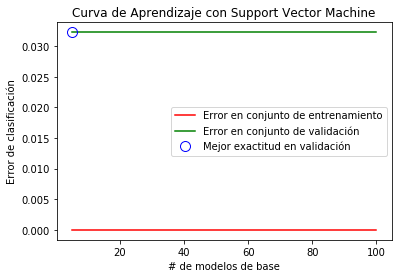

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(C_grid, svm_error_train,
        label='Error en conjunto de entrenamiento',
        color='red')
plt.plot(C_grid, svm_error_val,
        label='Error en conjunto de validación',
        color='green')
plt.plot(mejor_C, 1-mejor_score, 'o', markersize=10,
         label="Mejor exactitud en validación", fillstyle="none", c='b', mew=1)
plt.xlabel("# de modelos de base")
plt.ylabel("Error de clasificación")
plt.title("Curva de Aprendizaje con Support Vector Machine")
plt.legend(loc=0, numpoints=1)
plt.show()

In [21]:
from sklearn import metrics

y_pred_val = modelo_svm.predict_proba(X_test)[:,1]
fpr, tpr, umbrales = metrics.roc_curve(y_test.values.ravel(), y_pred_val)
auc_roc = metrics.roc_auc_score(y_test.values.ravel(), y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC SVM (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

AttributeError: predict_proba is not available when  probability=False